# DentalAnywhere Image Recognition System

## Dataset

Source of dataset: 
https://cs.uef.fi/pub/color/spectra/ODSI-DB/ and https://www.kaggle.com/shivam17299/oral-cancer-lips-and-tongue-images  
The dataset used in this project is obtained from the above URLs. 

There is a total of 309 images which are labeled with 12 classes as follows:

- AttritionErosion  
- Calculus   
- Dentine_caries  
- Gingivitis  
- Inflammation  
- Initial_caries
- Leukoplakia  
- Microfracture  
- Plague  
- Ulcer  
- Healthy  
- Cancer

In [1]:
# Import necessary libraries
import os
import zipfile
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing

In [2]:
# Load image files and append them as array
dataset=[]
datalabel=[]

rootdir= "OralData"

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        img=cv2.imread(os.path.join(subdir, file))
        resized=cv2.resize(img,(300,300))
        dataset.append(resized)
        datalabel.append(subdir[len(rootdir)+1:])

dataset = np.array(dataset)
datalabel = np.array(datalabel)

In [3]:
# Create a set of unique class for datalabel
unique_labels=set(datalabel)
unique_keys=set()
for i in range(1, len(unique_labels)+1,1):
    unique_keys.add(i)
unique_dict=dict(zip(unique_labels,unique_keys))
unique_dict

{'Calculus': 1,
 'Dentine_caries': 2,
 'Inflammation': 3,
 'Initial_caries': 4,
 'Healthy': 5,
 'Cancer': 6,
 'AttritionErosion': 7,
 'Microfracture': 8,
 'Gingivitis': 9,
 'Plague': 10,
 'Ulcer': 11,
 'Leukoplakia': 12}

In [4]:
datalabel_numeric=[]

for label in datalabel:
    if label in unique_dict:
        datalabel_numeric.append(unique_dict[label])
#datalabel_numeric

In [5]:
# Perform one-hot encoding of datalabel
from tensorflow.keras.utils import to_categorical

datalabel_encoded = to_categorical(datalabel_numeric)
datalabel_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

Comment: One-hot encoding is applied to ensure there is no relationship exists among the categorical variables. In other words, the assumption of the higher the categorical value, the better the category does not valid.

In [6]:
# Perform random splitting into training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, datalabel_encoded,
                                                    stratify=datalabel_encoded, 
                                                    test_size=0.10)

print('X_train:', len(X_train))
print('X_test:', len(X_test))
print('y_train:', len(y_train))
print('y_test:', len(y_test))

X_train: 278
X_test: 31
y_train: 278
y_test: 31


## Transfer Learning

Due to limited data available to train the model, transfer learning was applied by deploying the VGG16 pretrained model. The use of the pretrained model enabled us to leverage the previous learnings of the model on a much larger dataset. By transfering the weights that the network has learned from the previous task to our current task, the computational cost of training the model from scatch can be significantly reduced, at the same time improving the generalization in our model. Other pretrained models including InceptionV3 and ResNet50 were also used to train our model but VGG16 was selected as it yielded the best performance among the others.

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (300, 300, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

base_model.summary()

# Check number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [8]:
# Freeze the bottom 15 pre-trained layers, ensure they are not trainable and train only the top few layers
for layer in base_model.layers[:15]:
    layer.trainable = False

In [9]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 64 hidden units and ReLU activation
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 12 nodes for classification output
x = tf.keras.layers.Dense(len(unique_labels)+1, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), loss = 'categorical_crossentropy',metrics = ['acc'])

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train,
                                     batch_size=5)

validation_datagen = ImageDataGenerator(rescale=1./255)
      
validation_generator = validation_datagen.flow(X_test,y_test,
                                               batch_size=5)

In [11]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator)

Epoch 1/20
56/56 [==============================] - 187s 3s/step - loss: 5.2068 - acc: 0.2482 - val_loss: 2.1524 - val_acc: 0.2903
Epoch 2/20
56/56 [==============================] - 192s 3s/step - loss: 2.2391 - acc: 0.2842 - val_loss: 1.8819 - val_acc: 0.3548
Epoch 3/20
56/56 [==============================] - 187s 3s/step - loss: 2.1113 - acc: 0.3417 - val_loss: 2.0250 - val_acc: 0.3548
Epoch 4/20
56/56 [==============================] - 202s 4s/step - loss: 2.0104 - acc: 0.3561 - val_loss: 1.7760 - val_acc: 0.4194
Epoch 5/20
56/56 [==============================] - 205s 4s/step - loss: 1.7636 - acc: 0.3885 - val_loss: 2.0241 - val_acc: 0.3548
Epoch 6/20
56/56 [==============================] - 211s 4s/step - loss: 1.6574 - acc: 0.4209 - val_loss: 1.6975 - val_acc: 0.4194
Epoch 7/20
56/56 [==============================] - 200s 4s/step - loss: 1.5298 - acc: 0.4784 - val_loss: 1.9019 - val_acc: 0.4516
Epoch 8/20
56/56 [==============================] - 205s 4s/step - loss: 1.4456 - a

## Plot of training and validation accuracy and loss

Text(0.5, 1.0, 'Training and Validation Loss')

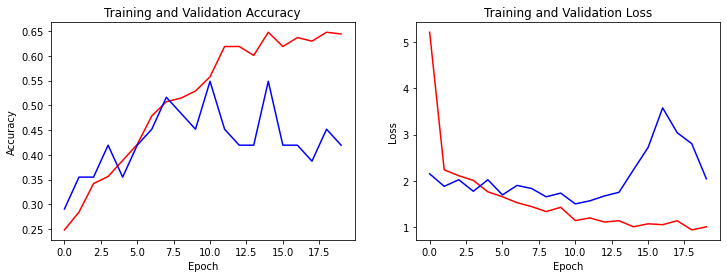

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

# Retrieve a list of list results on training and test datasets for each training epoch
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

# Plot training and validation accuracy per epoch
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(epochs, acc, 'r', label="Training Accuracy")
ax[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(epochs, loss, 'r', label="Training Loss")
ax[1].plot(epochs, val_loss, 'b', label="Validation Loss")
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training and Validation Loss')


Based on the graph above, the training accuracy (red) increases with smaller loss as number of epochs increases, inferring that the model is learning from the training data. At the 20th epoch, training accuracy of about 65% is obtained. However, the validation accuracy (blue) fluctuates with larger loss as number of epochs increases. This could be a sign of overfitting due to the small training data which causes the model to only learn the features of the training data, and hence less generalised to new data.

### Possible improvements:
- Larger dataset which better potrays the distinguishable features of each oral condition is required to improve the learning of the model
- Data augmentation can be applied to generate larger size of training data
- Pre-trained model which is trained on more relevant task might be more useful
- Further hyperparameter tuning (e.g. learning rate, number of epochs, batch size etc) of the CNN model is necessary

## Prediction using new data

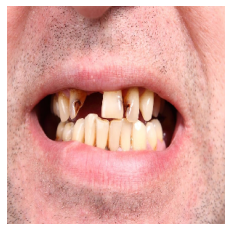

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [15]:
# predicting images
import numpy as np
from tensorflow.keras.preprocessing import image

trial_path = 'TrialData\Trial01.jpg'
trial_img = image.load_img(trial_path, target_size=(300, 300))
input_img = image.img_to_array(trial_img)
input_img = np.expand_dims(input_img, axis=0)

#images = np.vstack([x])
#img = mpimg.imread(path)
plt.imshow(trial_img)
plt.axis('Off')
plt.show()

class_pred = model.predict(input_img, batch_size=10)
class_pred

In [16]:
def decode(pred,top=3):
    return sorted(zip(pred[0],unique_labels),reverse=True)

In [17]:
result = decode(class_pred)
print(result)

[(1.0, 'AttritionErosion'), (0.0, 'Ulcer'), (0.0, 'Plague'), (0.0, 'Microfracture'), (0.0, 'Leukoplakia'), (0.0, 'Initial_caries'), (0.0, 'Inflammation'), (0.0, 'Healthy'), (0.0, 'Gingivitis'), (0.0, 'Dentine_caries'), (0.0, 'Cancer'), (0.0, 'Calculus')]


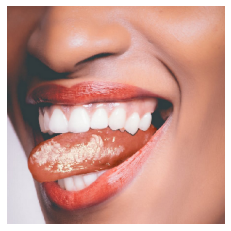

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [20]:
trial_path2 = 'TrialData\Trial06.jpg'
trial_img2 = image.load_img(trial_path2, target_size=(300, 300))
input_img2 = image.img_to_array(trial_img2)
input_img2 = np.expand_dims(input_img2, axis=0)

plt.imshow(trial_img2)
plt.axis('Off')
plt.show()

class_pred2 = model.predict(input_img2, batch_size=10)
class_pred2

In [21]:
result2 = decode(class_pred2)
print(result2)

[(1.0, 'AttritionErosion'), (0.0, 'Ulcer'), (0.0, 'Plague'), (0.0, 'Microfracture'), (0.0, 'Leukoplakia'), (0.0, 'Initial_caries'), (0.0, 'Inflammation'), (0.0, 'Healthy'), (0.0, 'Gingivitis'), (0.0, 'Dentine_caries'), (0.0, 'Cancer'), (0.0, 'Calculus')]
